# Linear Regression

## 1. Introduction

### In this section, we do the following:
- load all the relevant packages, 
- load the data 
- do a quick overview by using some descriptive statistics 
- Make a naive initial model to compare the later models 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from scipy import stats
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
file=r'D:\backup\Data Science\Public Data sets\Lin Regression\Life Expectancy Data.csv'
df=pd.read_csv(file)

In [231]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


"Life expectancy" is the target variable for prediction, or the dependent variable. While all others will be treated as independent variable, or predictor variables, in our analysis.
We'll do a quick naive check of model performance on our raw dataset so that we get an idea of the base performance score that we need to better.

In [232]:
df.drop(['Country','Status'],axis=1,inplace=True)

In [233]:
df.dropna(inplace=True)

In [234]:
dftrain, dftest = train_test_split(df,test_size=0.2,random_state=3)
dftrain.reset_index(drop=True,inplace=True)
dftest.reset_index(drop=True,inplace=True)
xtrain=dftrain.drop('Life expectancy ',axis=1)
ytrain=dftrain['Life expectancy ']

In [235]:
lm=LinearRegression()

lm.fit(xtrain,ytrain)

xtest=dftest.drop(['Life expectancy '],axis=1)

predict=lm.predict(xtest)

mean_absolute_error(dftest['Life expectancy '],predict)

2.772321169792129

As we can see, the linear model on this raw dataset gives a MAE score of 2.77. We'll try to bring this score by data pre-processing, performing some exploratory data analysis and feature selection.

## 2. Exploratory Data Analysis (EDA)

### We will now start modifying the data to get a better prediction result. In this section, we'll do the following:
- split the data into testing and training data
- Deal with missing values
- Remove outliers
- Feature selection/engineering 

In [347]:
df=pd.read_csv(file)

### Data split
Let's split the data into training and testing data, label them, and then merge them again so that all the data pre-processing steps are performed on the entire dataset. Splitting is done for testing our model performance on out of sample(testing) data.  

In [4]:
dftrain, dftest = train_test_split(df,test_size=0.2,random_state=2)
dftrain['data']='train'
dftest['data']='test'
dftrain.reset_index(drop=True,inplace=True)
dftest.reset_index(drop=True,inplace=True)
df=pd.concat([dftrain,dftest],axis=0,ignore_index=True)

### Descriptiive Statistics
Now lets look at some descriptive statistics of all the variables in the data

In [37]:
df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,data
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,...,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000,2938
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,Estonia,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2350
mean,NaN,2007.518720,NaN,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,...,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793,NaN
std,NaN,4.613841,NaN,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,...,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920,NaN
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,...,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,NaN
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,...,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000,NaN
50%,NaN,2008.000000,NaN,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,...,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000,NaN
75%,NaN,2012.000000,NaN,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,...,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000,NaN


In [15]:
list(zip(df.columns,df.dtypes,df.nunique(),df.isnull().sum()))

[('Country', dtype('O'), 193, 0),
 ('Year', dtype('int64'), 16, 0),
 ('Status', dtype('O'), 2, 0),
 ('Life expectancy ', dtype('float64'), 362, 10),
 ('Adult Mortality', dtype('float64'), 425, 10),
 ('infant deaths', dtype('int64'), 209, 0),
 ('Alcohol', dtype('float64'), 1076, 194),
 ('percentage expenditure', dtype('float64'), 2328, 0),
 ('Hepatitis B', dtype('float64'), 87, 553),
 ('Measles ', dtype('int64'), 958, 0),
 (' BMI ', dtype('float64'), 608, 34),
 ('under-five deaths ', dtype('int64'), 252, 0),
 ('Polio', dtype('float64'), 73, 19),
 ('Total expenditure', dtype('float64'), 818, 226),
 ('Diphtheria ', dtype('float64'), 81, 19),
 (' HIV/AIDS', dtype('float64'), 200, 0),
 ('GDP', dtype('float64'), 2490, 448),
 ('Population', dtype('float64'), 2278, 652),
 (' thinness  1-19 years', dtype('float64'), 200, 34),
 (' thinness 5-9 years', dtype('float64'), 207, 34),
 ('Income composition of resources', dtype('float64'), 625, 167),
 ('Schooling', dtype('float64'), 173, 163),
 ('data'

This gives a comprehensive details about the data types, unique values and number of missing vallues for all variable columns. 

### Missing value imputation
Let's deal with missing values next. We can see from the descriptive statistics that there are way too many missing vlaues for us to drop all of them from our dataset. Thus, we'll deal with missing values by imputing the missing values with one of the central tendencies of each variable. Median gives a better estimate of central tendency than mean, since it's less affected due to presence of outliers. We'll subset the data containing only training data and then get the median to avoid testing data leak

In [5]:
df.dropna(inplace=True,subset=['Life expectancy '])

In [350]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                            193
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                32
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                443
Population                         644
 thinness  1-19 years               32
 thinness 5-9 years                 32
Income composition of resources    160
Schooling                          160
data                                 0
dtype: int64

In [9]:
cols=['Year', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

In [6]:
country_list= df.Country.unique()

In [10]:
for country in country_list:
    df.loc[df.Country==country,cols]=df.loc[df.Country==country,cols].interpolate(limit_direction='both')

In [11]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                             16
percentage expenditure               0
Hepatitis B                        144
Measles                              0
 BMI                                32
under-five deaths                    0
Polio                                0
Total expenditure                   32
Diphtheria                           0
 HIV/AIDS                            0
GDP                                400
Population                         640
 thinness  1-19 years               32
 thinness 5-9 years                 32
Income composition of resources    160
Schooling                          160
data                                 0
dtype: int64

In [12]:
for col in cols:
    if (df[col].isnull().sum()<50) :
        df.dropna(inplace=True,subset=[col])

In [14]:
df.fillna(df[df['data']=='train'].median(),inplace=True)

In [15]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
data                               0
dtype: int64

### Dealing with object columns

 Let's deal with the object columns next. We can see 'Country' has too many unique values to be converted into dummies. So we'll drop that and make dummy variable for 'Status'.

In [16]:
df=pd.get_dummies(df,columns=['Status'],drop_first=True)
df.drop(['Country'],axis=1,inplace=True)

### Data Visualization

In [ ]:
df.corr()['Life expectancy ']

Looking at the correlation values, we can clearly see that the variables 'Schooling', 'Income composition of resources' and 'Adult Mortality' have the strongest correlation with our dependent variable 'Life expectancy'. Let's do some visualization next to get some more insight into the kind of relationship that the dependent varibales may have with the independent variable.

Simultaneously, we'll check for presence of ouliers in each variable by using the probability distribution function (PDF) and their descriptive statistics. Let's look at the descriptive statistics first.

In [71]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,...,2864.000000,2864.000000,2864.000000,2864.000000,2.864000e+03,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,2007.500000,69.441061,162.533869,30.236732,4.673404,756.272834,79.720670,2431.046089,38.415049,41.818785,...,5.939694,82.743890,1.759497,6737.761239,1.035508e+07,4.833834,4.865957,0.633446,12.102968,0.821229
std,4.610577,9.461907,123.918966,119.380116,4.054356,2010.146007,25.291325,11600.441817,19.978256,162.393455,...,2.471556,23.368301,5.136748,13444.008750,5.468675e+07,4.441339,4.531330,0.203241,3.161699,0.383227
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,0.000000
25%,2003.750000,63.575000,73.000000,0.000000,0.960000,6.048798,75.000000,0.000000,19.300000,0.000000,...,4.278750,79.000000,0.100000,562.253866,3.929105e+05,1.600000,1.500000,0.508000,10.300000,1.000000
50%,2007.500000,72.300000,142.000000,3.000000,3.865000,69.948269,91.000000,17.000000,43.800000,4.000000,...,5.755000,93.000000,0.100000,1732.857979,1.383743e+06,3.300000,3.300000,0.677000,12.300000,1.000000
75%,2011.250000,75.800000,224.000000,20.000000,7.812500,459.530125,96.000000,343.250000,56.200000,25.000000,...,7.470000,97.000000,0.700000,4976.001630,4.603027e+06,7.200000,7.200000,0.775000,14.200000,1.000000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,...,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,1.000000


#### Life expectancy

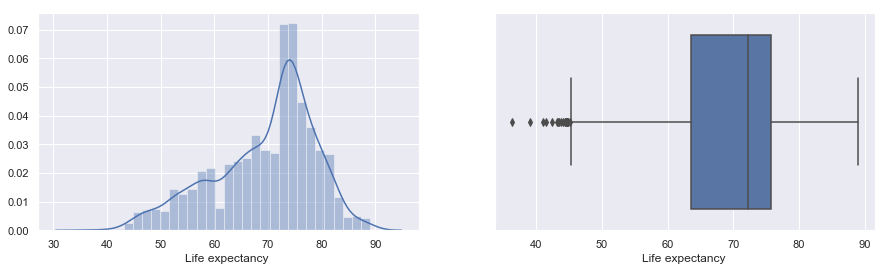

In [74]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,4))
sns.distplot(df['Life expectancy '],ax=ax1)
sns.boxplot(df['Life expectancy '],ax=ax2)
plt.show()

From the descriptive statistics and the PDF plot, we see 'Life expectancy' is fairly normally distributed with range from 
36 to 90. There is no  need to remove obesevations as the range and distribution seems fine.

In [72]:
df['Life expectancy '].quantile(0.01)

45.6

In [17]:
new_df=df[df['Life expectancy ']>45]

We'll now simultaneously plot the following two graphs for each variable:
- The probability distribution functions (PDF) of each variables to better visualize there distribution.
- The regplot function from seaborn package which plots a scatter plot and fits a regression line with the data.

#### Infant deaths

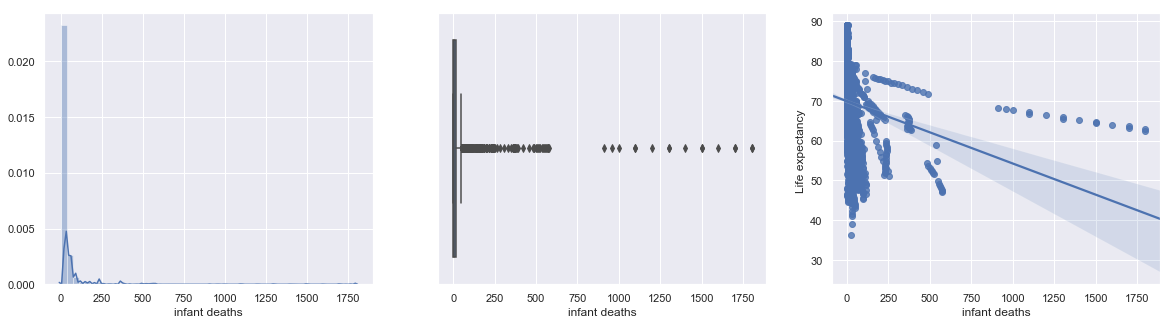

In [76]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='infant deaths',y='Life expectancy ',data=df,ax=ax2)
sns.distplot(df['infant deaths'],ax=ax0)
sns.boxplot(df['infant deaths'],ax=ax1)
plt.show()

It's clear that this variable has multiple outliers on the higher side and it's making the visualization of regplot somewhat unclear. A quick search about infant mortality also tells us that infant mortality is number of deaths of chilren below 1 year old per 1000 population. This usually ranges from 0 to 200 deaths per 1000. Which clearly shows that there are outlers in this data. We'll use a rounded number of 200 to subset our data and create a new data frame with the modified columns. Let's visualize what the plots looks like with this new data.

In [18]:
new_df=new_df[new_df['infant deaths']<200]

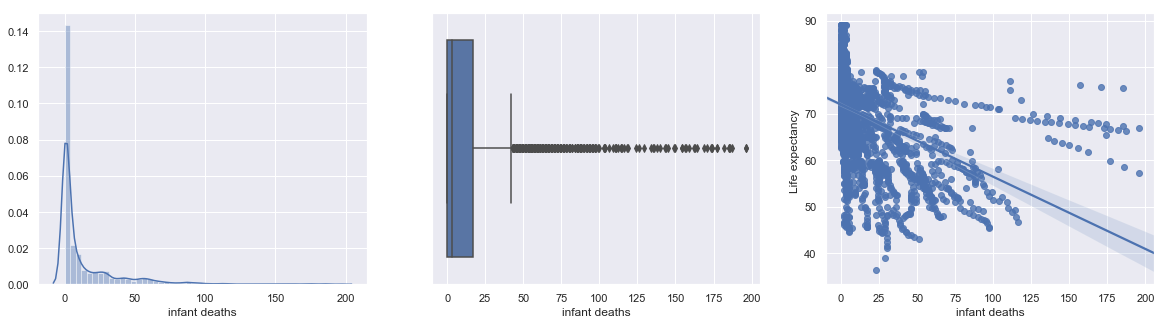

In [80]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='infant deaths',y='Life expectancy ',data=new_df,ax=ax2)
sns.distplot(new_df['infant deaths'],ax=ax0)
sns.boxplot(new_df['infant deaths'],ax=ax1)
plt.show()

We can see that even thpugh the variable is not normally distributed, it's free of outliers, and that gives the scatterplot a more linear relationship. We'll follow the same process of plotting the PDFs and scatter plots, referenceing the descriptive statistics and the correlation table for each of the variable to rmeove outliers or deal with transforming the data accordingly.

#### Under-five deaths

'Under-five deaths' would also contain the deaths that happened below the age of 1, which would mean it would be correlated to 'infant deaths'. This would lead to multicollinearity in the data. We'll use a modified column by subtracting 'infant deaths' from 'under-five deaths', giving  us only the number of deaths from age 1 to 5.

In [19]:
new_df['under-five_deaths_new']=new_df['under-five deaths ']-new_df['infant deaths']

In [82]:
new_df[['infant deaths','under-five deaths ','under-five_deaths_new']].head()

,infant deaths,under-five deaths,under-five_deaths_new
0,0,0,0
1,174,231,57
2,14,21,7
3,9,11,2
4,32,39,7


In [ ]:
new_df['under-five_deaths_new'].describe()

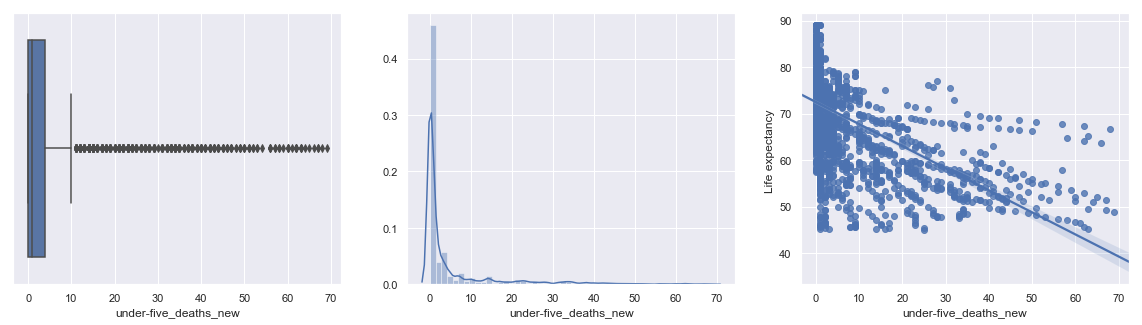

In [26]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df['under-five_deaths_new'],ax=ax0)
sns.distplot(new_df['under-five_deaths_new'],ax=ax1)
sns.regplot(x='under-five_deaths_new',y='Life expectancy ',data=new_df,ax=ax2)
plt.show()

In [25]:
new_df=new_df[new_df['under-five_deaths_new']<70]

Statistical summary of modified under-five deaths column seems to be accurate without the presence of outliers, even though the PDF is not normally distributed. The scatter plot shows approximate linear relationship. We'll drop the original 'under-five deaths' column from our new data.

In [28]:
new_df.drop('under-five deaths ',axis=1,inplace=True)

#### Adult Mortality

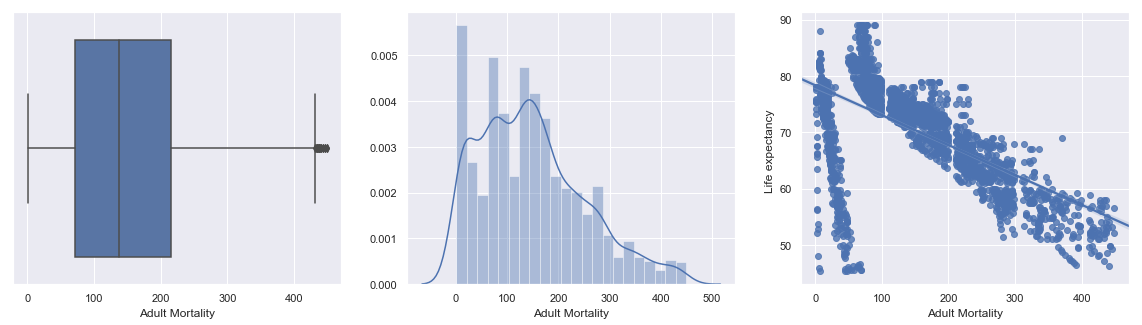

In [32]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df['Adult Mortality'],ax=ax0)
sns.distplot(new_df['Adult Mortality'],ax=ax1)
sns.regplot(x='Adult Mortality',y='Life expectancy ',data=new_df,ax=ax2)

plt.show()

We can visually verify that 'Adult Mortality' has high correlation with Life expectancy. We'll keep 'Adult Mortality' threshold as 450, and remove the rest of the observations as outliers.

In [31]:
new_df=new_df.loc[new_df['Adult Mortality']<450]

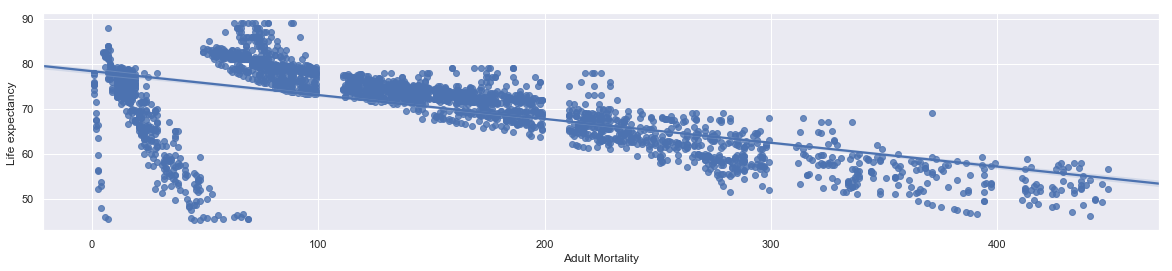

In [34]:
plt.figure(figsize=(20,4))
sns.regplot(x='Adult Mortality',y='Life expectancy ',data=new_df)
plt.show()

Making a flag variable for adult mortality below 55

In [35]:
new_df['A_Mortality>55']=(new_df['Adult Mortality']<55).astype('int')

In [36]:
new_df[['A_Mortality>55','Adult Mortality','Life expectancy ']].corr()

,A_Mortality>55,Adult Mortality,Life expectancy
A_Mortality>55,1.000000,-0.598913,-0.039231
Adult Mortality,-0.598913,1.000000,-0.629575
Life expectancy,-0.039231,-0.629575,1.000000


#### Measles & Population

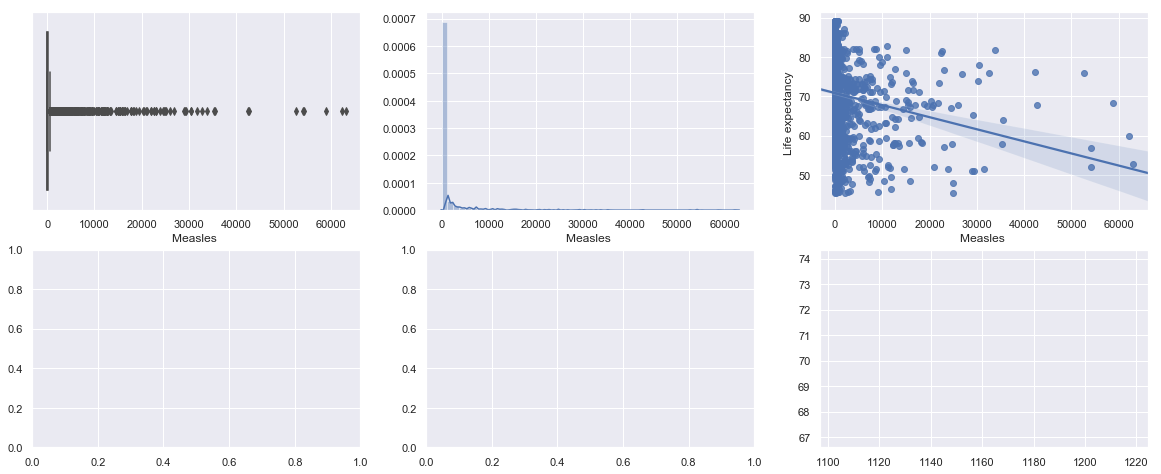

In [43]:
fig1,((ax1,ax2,ax5),(ax3,ax4,ax6))=plt.subplots(2,3,figsize=(20,8))
sns.boxplot(new_df['Measles '],ax=ax1)
sns.distplot(new_df['Measles '],ax=ax2)
sns.regplot(x='Measles ',y='Life expectancy ',data=new_df,ax=ax5)
sns.boxplot(new_df['Population'],ax=ax3)
sns.regplot(x='Population',y='Life expectancy ',data=new_df,ax=ax4)
sns.distplot(new_df['Population'],ax=ax6)
plt.show()

It's clear that 'Measles' and 'Population' individually are not correlated in any way with 'Life expectancy'. We'll drop these two variables from our data since they would not be significant for our model.

In [41]:
new_df.drop(['Population','Measles '],axis=1,inplace=True)

#### BMI

In [ ]:
new_df[' BMI '].describe()

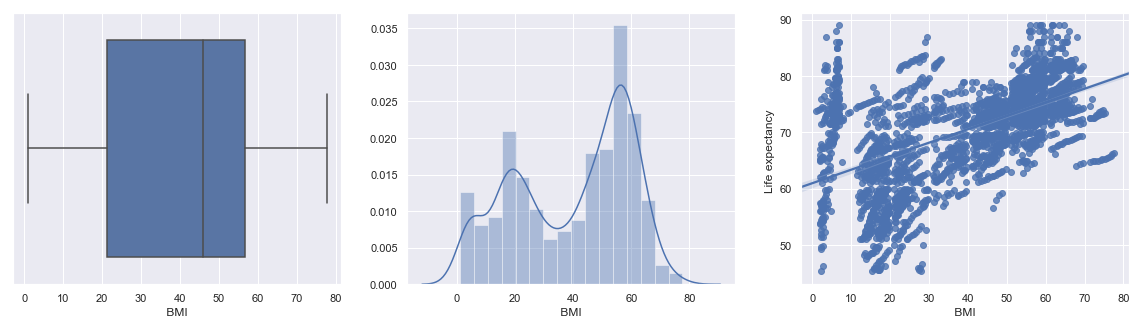

In [44]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df[' BMI '],ax=ax0)
sns.distplot(new_df[' BMI '],ax=ax1)
sns.regplot(x=' BMI ',y='Life expectancy ',data=new_df,ax=ax2)

plt.show()

In [ ]:
new_df[[' BMI ','Life expectancy ']].corr()

Since BMI has multiple modes in the distribution, we can bin BMI into categories that qualify each as underweight (<18.5), normal (18.5-25), overweight (25-30) and further. This would give a better categorization for the variable. We can drop teh ones which don't have much significance while testing the model performance later.

In [45]:
new_df['bmi_0to18.5']=(new_df[' BMI ']<18.5).astype('int')
new_df['bmi_18.5to25']=((new_df[' BMI ']<25)&(new_df[' BMI ']>18.5)).astype('int')
new_df['bmi_25to30']=((new_df[' BMI ']<30)&(new_df[' BMI ']>25)).astype('int')
new_df['bmi_30to35']=((new_df[' BMI ']<35)&(new_df[' BMI ']>30)).astype('int')
new_df['bmi_40']=(new_df[' BMI ']>40).astype('int')

In [46]:
new_df.drop([' BMI '],axis=1,inplace=True)

#### Diphtheria 

In [ ]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df['Diphtheria '],ax=ax0)
sns.distplot(new_df['Diphtheria '],ax=ax1)
sns.regplot(x='Diphtheria ',y='Life expectancy ',data=new_df,ax=ax2)

plt.show()

Like BMI, we can bin Diphtheria according to the distribution.

In [48]:
new_df.shape

(2674, 26)

In [50]:
new_df=new_df.loc[new_df['Diphtheria ']>60]

In [52]:
new_df['Diphtheria<20']=(df['Diphtheria ']<20).astype('int')
new_df['Diphtheria_60to80']=((new_df['Diphtheria ']>60)&(new_df['Diphtheria ']<80)).astype('int')
new_df['Diphtheria_80to100']=((new_df['Diphtheria ']>80)&(new_df['Diphtheria ']<100)).astype('int')
new_df.drop('Diphtheria ',axis=1,inplace=True)

#### HIV/AIDS

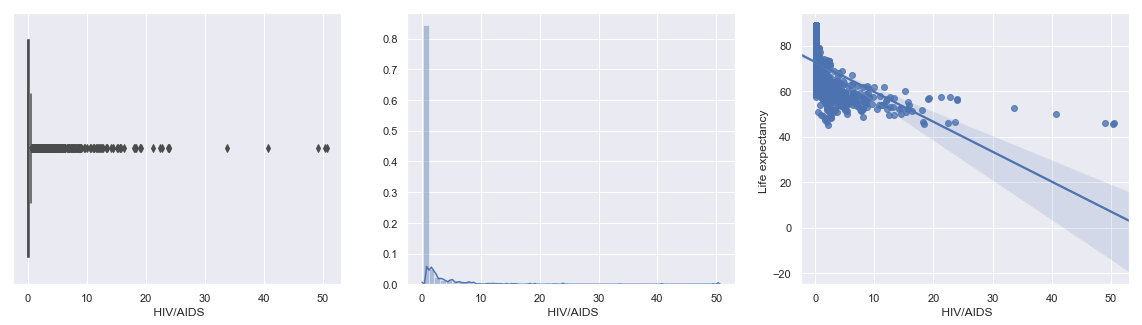

In [54]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df[' HIV/AIDS'],ax=ax0)
sns.distplot(new_df[' HIV/AIDS'],ax=ax1)
sns.regplot(x=' HIV/AIDS',y='Life expectancy ',data=new_df,ax=ax2)

plt.show()


In [127]:
new_df=new_df.loc[new_df[' HIV/AIDS']<17.5]

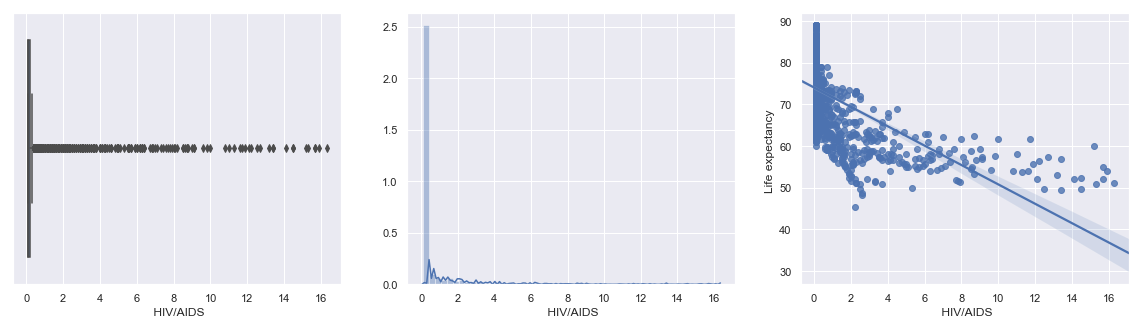

In [128]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df[' HIV/AIDS'],ax=ax0)
sns.distplot(new_df[' HIV/AIDS'],ax=ax1)
sns.regplot(x=' HIV/AIDS',y='Life expectancy ',data=new_df,ax=ax2)

plt.show()

#### Percentage expenditure

In [20]:
new_df['percentage expenditure'].describe()

count     2852.000000
mean       759.307948
std       2013.888573
min          0.000000
25%          5.260844
50%         70.143724
75%        463.749215
max      19479.911610
Name: percentage expenditure, dtype: float64

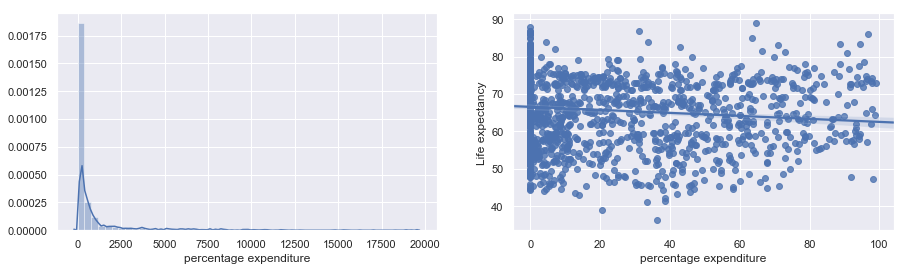

In [23]:
fig, (ax2, ax1)=plt.subplots(1,2,figsize=(15,4))
sns.regplot(x='percentage expenditure',y='Life expectancy ',data=new_df[new_df['percentage expenditure']<100],ax=ax1)
sns.distplot(new_df['percentage expenditure'],ax=ax2)
plt.show()

Percentage expenditure denotes the 'Expenditure on health as a percentage of GDP per capita'. Since it's a percentage, it's value can't be more than 100. But we can see that there are a lot of values more than 100, which may mean discripancy in data. So, let's drop the column from our data.

In [55]:
new_df.drop(['percentage expenditure'],axis=1,inplace=True)

####  Thinness  1-19 years & Thinness  5-9 years

In [ ]:
new_df[[' thinness  1-19 years',' thinness 5-9 years']].describe()

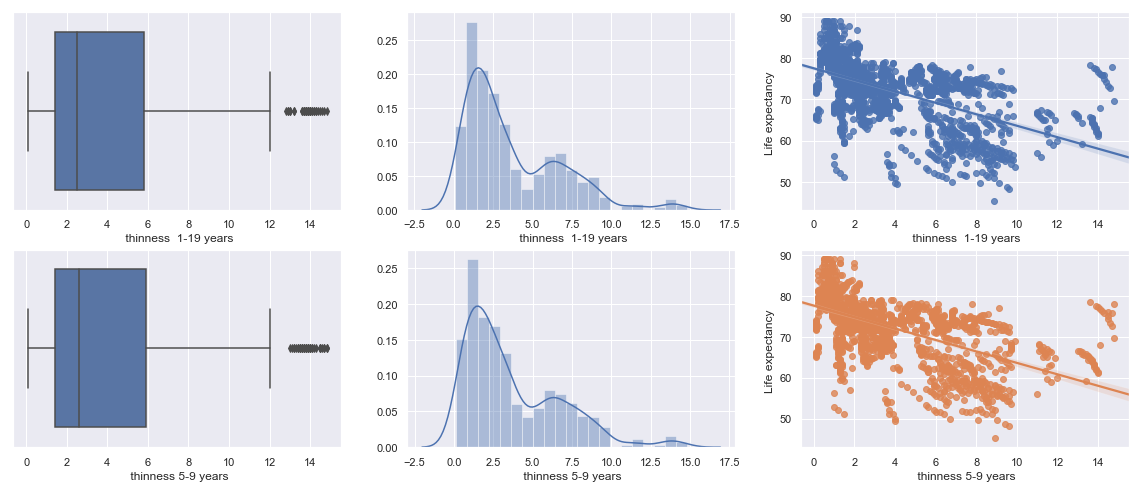

In [130]:
fig1,((ax1,ax2,ax5),(ax3,ax4,ax6))=plt.subplots(2,3,figsize=(20,8))
sns.boxplot(new_df[' thinness  1-19 years'],ax=ax1)
sns.distplot(new_df[' thinness  1-19 years'],ax=ax2)
sns.regplot(x=' thinness  1-19 years',y='Life expectancy ',data=new_df,ax=ax5)
sns.boxplot(new_df[' thinness 5-9 years'],ax=ax3)
sns.distplot(new_df[' thinness 5-9 years'],ax=ax4)
sns.regplot(x=' thinness 5-9 years',y='Life expectancy ',data=new_df,ax=ax6)

plt.show()

In [818]:
new_df[' thinness  1-19 years'].quantile(0.98)

15.400000000000002

In [131]:
new_df=new_df.loc[new_df[' thinness  1-19 years']<12.0]

In [57]:
new_df=new_df.loc[new_df[' thinness 5-9 years']<15.0]

Can drop one

#### Income composition of resources

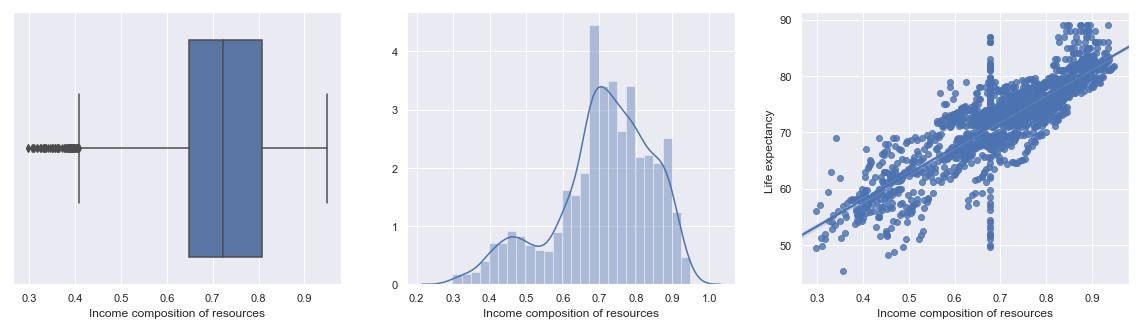

In [132]:
fig, (ax0, ax1,ax2)=plt.subplots(1,3,figsize=(20,5))
sns.boxplot(new_df['Income composition of resources'],ax=ax0)
sns.distplot(new_df['Income composition of resources'],ax=ax1)
sns.regplot(x='Income composition of resources',y='Life expectancy ',data=new_df,ax=ax2)

plt.show()


In [133]:
new_df=new_df.loc[new_df['Income composition of resources']>0.35]

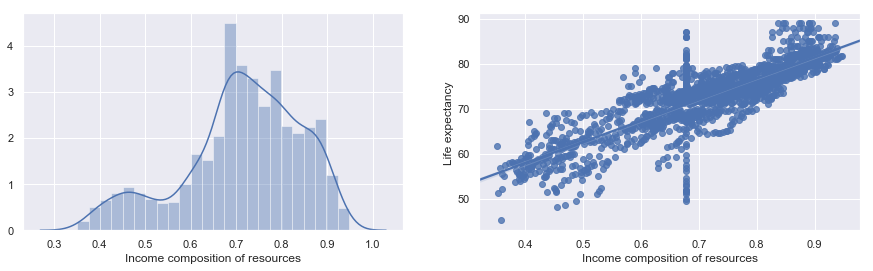

In [134]:
fig, (ax2, ax1)=plt.subplots(1,2,figsize=(15,4))
sns.regplot(x='Income composition of resources',y='Life expectancy ',data=new_df,ax=ax1)
sns.distplot(new_df['Income composition of resources'],ax=ax2)
plt.show()

#### Total expenditure

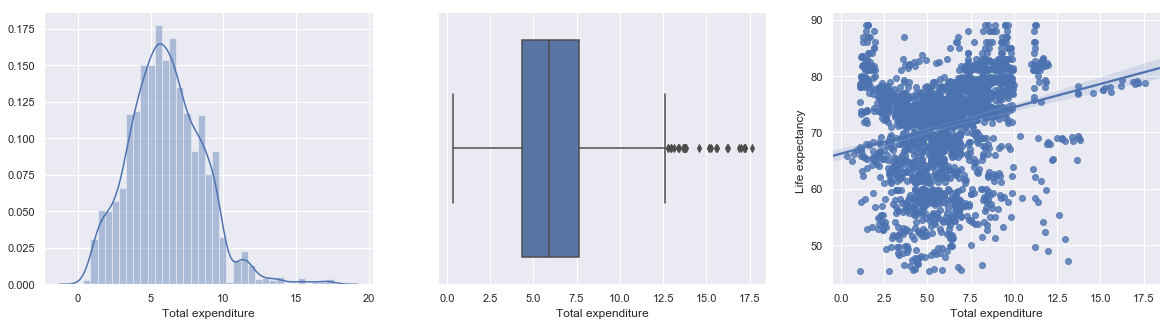

In [535]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='Total expenditure',y='Life expectancy ',data=new_df,ax=ax3)
sns.boxplot(new_df['Total expenditure'],ax=ax2)
sns.distplot(new_df['Total expenditure'],ax=ax1)
plt.show()

In [135]:
new_df=new_df[new_df['Total expenditure']<12.5]

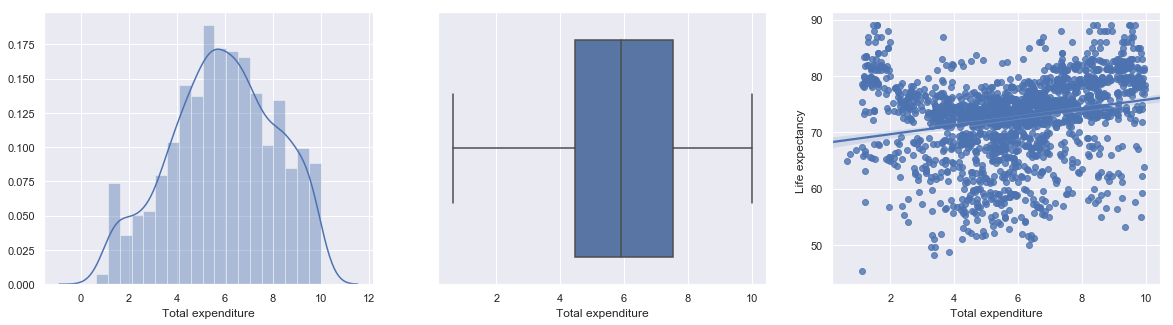

In [136]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='Total expenditure',y='Life expectancy ',data=new_df,ax=ax3)
sns.boxplot(new_df['Total expenditure'],ax=ax2)
sns.distplot(new_df['Total expenditure'],ax=ax1)
plt.show()

In [137]:
new_df[['Total expenditure','Life expectancy ']].corr()

,Total expenditure,Life expectancy
Total expenditure,1.000000,0.229641
Life expectancy,0.229641,1.000000


#### Alcohol

In [ ]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='Alcohol',y='Life expectancy ',data=new_df,ax=ax3)
sns.boxplot(new_df['Alcohol'],ax=ax2)
sns.distplot(new_df['Alcohol'],ax=ax1)
plt.show()


In [60]:
new_df.drop(['Alcohol'],axis=1,inplace=True)

#### Hepatitis B

In [ ]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='Hepatitis B',y='Life expectancy ',data=new_df,ax=ax3)
sns.boxplot(new_df['Hepatitis B'],ax=ax2)
sns.distplot(new_df['Hepatitis B'],ax=ax1)
plt.show()


In [61]:
new_df['Hepatitis_0to20']=(new_df['Hepatitis B']<20).astype('int')
new_df['Hepatitis_60to85']=((new_df['Hepatitis B']>60)&(new_df['Hepatitis B']<85)).astype('int')
new_df['Hepatitis_85to100']=((new_df['Hepatitis B']>85)&(new_df['Hepatitis B']<100)).astype('int')

In [62]:
new_df.drop(['Hepatitis B'],axis=1,inplace=True)

#### Polio

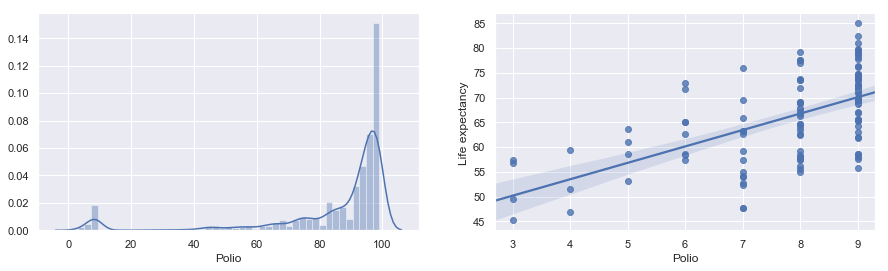

In [783]:
fig, (ax2, ax1)=plt.subplots(1,2,figsize=(15,4))
sns.regplot(x='Polio',y='Life expectancy ',data=new_df[new_df['Polio']<15],ax=ax1)
sns.distplot(new_df['Polio'],ax=ax2)
plt.show()

In [63]:
new_df['polio<15']=(new_df['Polio']<15).astype('int')

In [64]:
new_df['polio>80']=(new_df['Polio']>80).astype('int')

In [65]:
new_df.drop(['Polio'],axis=1,inplace=True)

#### GDP

In [ ]:
new_df[['GDP','Life expectancy ']].corr()

In [ ]:
new_df['GDP'].describe()

In [ ]:
new_df['GDP'].quantile(.2)

In [66]:
new_df=new_df.loc[new_df['GDP']>250]

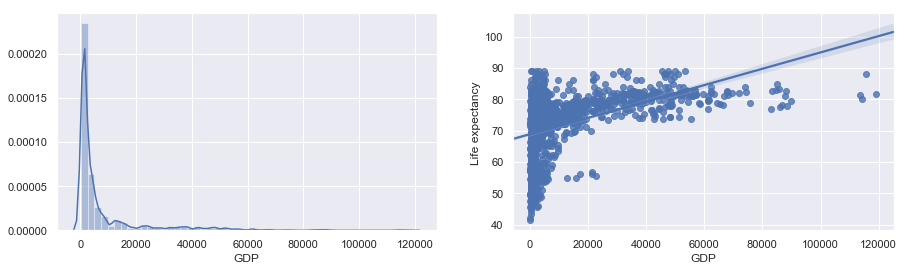

In [439]:
fig, (ax2, ax1)=plt.subplots(1,2,figsize=(15,4))
sns.regplot(x='GDP',y='Life expectancy ',data=new_df,ax=ax1)
sns.distplot(new_df['GDP'],ax=ax2)
plt.show()

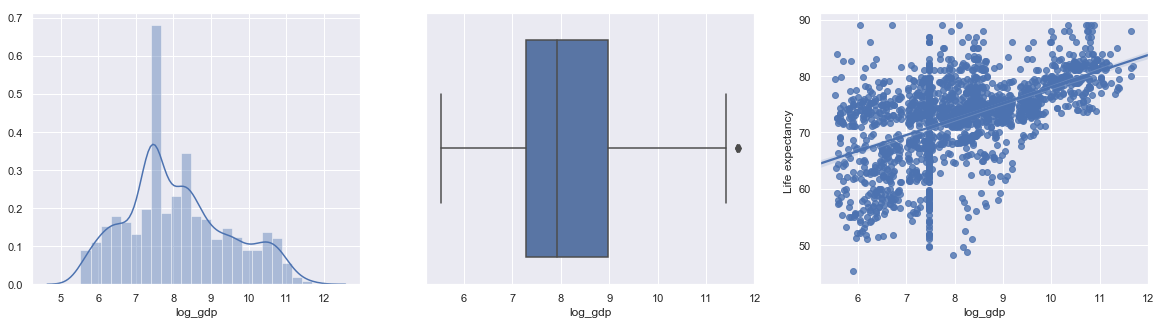

In [141]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='log_gdp',y='Life expectancy ',data=new_df,ax=ax3)
sns.boxplot(new_df['log_gdp'],ax=ax2)
sns.distplot(new_df['log_gdp'],ax=ax1)
plt.show()


In [26]:
new_df[['log_gdp','GDP','Life expectancy ']].corr()

,log_gdp,GDP,Life expectancy
log_gdp,1.000000,0.796807,0.566499
GDP,0.796807,1.000000,0.433608
Life expectancy,0.566499,0.433608,1.000000


In [68]:
new_df.drop(['GDP'],axis=1,inplace=True)

#### Schooling

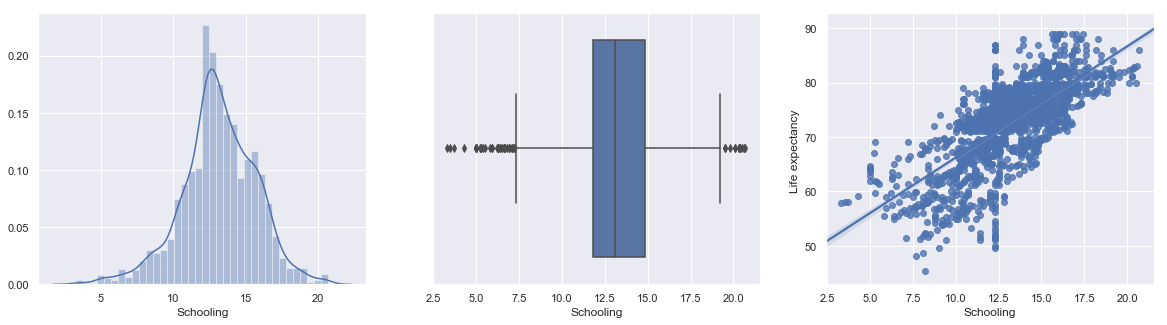

In [142]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
sns.regplot(x='Schooling',y='Life expectancy ',data=new_df,ax=ax3)
sns.boxplot(new_df['Schooling'],ax=ax2)
sns.distplot(new_df['Schooling'],ax=ax1)
plt.show()

#### Year

In [35]:
new_df['Year'].describe()

count    2381.000000
mean     2007.966401
std         4.527289
min      2000.000000
25%      2004.000000
50%      2008.000000
75%      2012.000000
max      2015.000000
Name: Year, dtype: float64

In [36]:
new_df[['Year','Life expectancy ']].corr()

,Year,Life expectancy
Year,1.000000,0.097159
Life expectancy,0.097159,1.000000


Not much correlation between year and life expectancy may suggest we should drop the year variable. But let's dig a bit deeper and find out the median life expectancy for each year and plot a line plot with that data. 

In [50]:
year_data=new_df.groupby(by='Year').median()

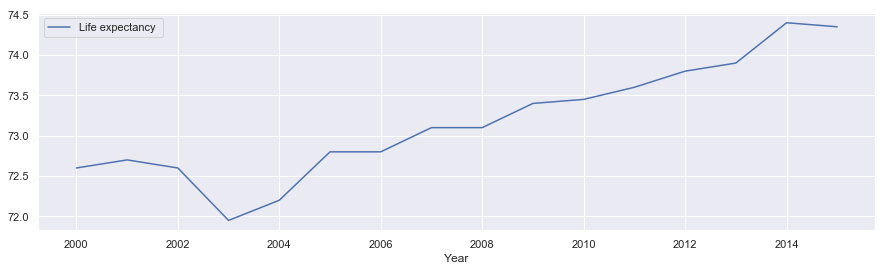

In [108]:
year_data[['Life expectancy ']].plot(kind='line',figsize=(15,4))
plt.show()

We can see gradual increase of life expectancy as the years have progressed. Let's bin the years into categories where Lif expectancy drops between 2002-2004, to get a better response from the model and drop the original column.

In [69]:
new_df['year<=2002']=(new_df['Year']<=2002).astype('int')
new_df['year=2003']=(new_df['Year']==2003).astype('int')
new_df['year>2003']=(new_df['Year']>2003).astype('int')

In [70]:
new_df.drop(["Year"],axis=1,inplace=True)

## 3. Model Selection

### Splitting training and testing data

In [192]:
dftrain=new_df.loc[new_df['data']=='train']
dftest=new_df.loc[new_df['data']=='test']
dftrain.reset_index(drop=True,inplace=True)
dftest.reset_index(drop=True,inplace=True)
dftrain.drop(['data'],axis=1,inplace=True)
dftest.drop(['data'],axis=1,inplace=True)

In [193]:
xtrain=dftrain.drop(['Life expectancy '],axis=1)
ytrain=dftrain['Life expectancy ']
xtest=dftest.drop('Life expectancy ',axis=1)
ytest=dftest['Life expectancy ']

### Scaling

In [194]:
scaler=StandardScaler()
scaler.fit(xtrain)
scaled_df_train=pd.DataFrame(scaler.transform(xtrain),columns=xtrain.columns)
scaled_df_test=pd.DataFrame(scaler.transform(xtest),columns=xtest.columns)

### Removing Multicollinearity

In [155]:
new_df.corr()['Life expectancy ']

Life expectancy                    1.000000
Adult Mortality                   -0.674703
infant deaths                     -0.443838
Measles                           -0.107618
Total expenditure                  0.229641
 HIV/AIDS                         -0.608718
 thinness  1-19 years             -0.617071
 thinness 5-9 years               -0.626908
Income composition of resources    0.840584
Schooling                          0.718986
Status_Developing                 -0.493925
under-five_deaths_new             -0.574535
A_Mortality>55                    -0.010653
bmi_0to18.5                       -0.182753
bmi_18.5to25                      -0.425649
bmi_25to30                        -0.080465
bmi_30to35                        -0.037902
bmi_40                             0.471381
Diphtheria<20                           NaN
Diphtheria_60to80                 -0.438860
Diphtheria_80to100                 0.438860
Hepatitis_0to20                    0.013562
Hepatitis_60to85                

In [156]:
scaled_df_train.corr()

,Adult Mortality,infant deaths,Total expenditure,HIV/AIDS,thinness 1-19 years,Income composition of resources,Status_Developing,under-five_deaths_new,A_Mortality>55,bmi_0to18.5,bmi_18.5to25,bmi_25to30,bmi_30to35,Diphtheria_60to80,Hepatitis_0to20,Hepatitis_60to85,polio<15,year<=2002,year=2003
Adult Mortality,1.000000,0.330685,-0.121902,0.502974,0.407726,-0.566200,0.326580,0.414101,-0.595368,0.136189,0.312066,0.101073,0.086165,0.289249,0.003412,0.297287,0.088738,-0.054117,-0.005353
infant deaths,0.330685,1.000000,-0.116916,0.343873,0.254084,-0.382814,0.239402,0.880882,-0.041008,0.184091,0.288003,0.054075,-0.016709,0.332275,-0.036860,0.339252,0.085233,-0.017135,-0.022604
Total expenditure,-0.121902,-0.116916,1.000000,-0.028489,-0.358237,0.167462,-0.293019,-0.110349,0.011714,-0.020561,-0.114557,-0.123320,-0.058055,-0.137675,0.008810,-0.110474,-0.028209,-0.025667,0.019812
HIV/AIDS,0.502974,0.343873,-0.028489,1.000000,0.380184,-0.474741,0.182583,0.513481,0.003845,0.197007,0.272568,0.044326,0.168372,0.314206,-0.010324,0.316132,0.071507,-0.058232,-0.018158
thinness 1-19 years,0.407726,0.254084,-0.358237,0.380184,1.000000,-0.586852,0.450739,0.360772,-0.008709,0.184168,0.356013,0.189922,0.159605,0.222148,-0.029670,0.205436,0.036303,-0.031089,-0.002921
Income composition of resources,-0.566200,-0.382814,0.167462,-0.474741,-0.586852,1.000000,-0.525864,-0.483946,0.005097,-0.221789,-0.408953,-0.121395,-0.013359,-0.442370,0.013800,-0.386993,-0.107112,-0.005561,-0.011752
Status_Developing,0.326580,0.239402,-0.293019,0.182583,0.450739,-0.525864,1.000000,0.211941,-0.032379,0.068547,0.123632,0.062975,0.046738,0.188720,0.037471,0.177270,0.091468,-0.049238,-0.017888
under-five_deaths_new,0.414101,0.880882,-0.110349,0.513481,0.360772,-0.483946,0.211941,1.000000,-0.013631,0.242828,0.382573,0.062719,-0.037572,0.410138,-0.044387,0.398192,0.099923,-0.040555,-0.022949
A_Mortality>55,-0.595368,-0.041008,0.011714,0.003845,-0.008709,0.005097,-0.032379,-0.013631,1.000000,-0.029140,-0.027720,-0.055350,-0.047666,-0.006099,-0.016876,-0.040457,-0.018423,0.046846,-0.000831
bmi_0to18.5,0.136189,0.184091,-0.020561,0.197007,0.184168,-0.221789,0.068547,0.242828,-0.029140,1.000000,-0.116175,-0.093142,-0.073305,0.106412,0.006087,0.074812,0.057684,-0.079036,-0.026070


In [449]:
new_df.columns

Index(['Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'Hepatitis B', ' BMI ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'data', 'Status_Developing', 'under-five_deaths_new', 'A_Mortality>55',
       'log_gdp'],
      dtype='object')

In [112]:
variables=xtrain.drop(['year>2003','Diphtheria_80to100','Schooling','log_gdp',' thinness 5-9 years',
                      'polio>80','bmi_40','Hepatitis_85to100'],axis=1)
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]

vif['features']=variables.columns

In [113]:
vif.sort_values(by='VIF',ascending=False).head(6)

,VIF,features
6,10.949152,Income composition of resources
3,8.691124,Total expenditure
0,7.715811,Adult Mortality
8,6.867177,under-five_deaths_new
1,6.210809,infant deaths
7,5.722640,Status_Developing


After multiple trials of removing the variables with VIF and which simultaneously doesn't worsen the performance of prediction on testing data below in section 4, the followng columns are decided to be dropped and the final data frame is created.

In [197]:
scaled_df_train=xtrain.drop(['year>2003','Diphtheria_80to100','Schooling','log_gdp',' thinness 5-9 years',
                            'polio>80','bmi_40','Hepatitis_85to100','Measles ','Diphtheria<20'],axis=1)
scaled_df_test=xtest.drop(['year>2003','Diphtheria_80to100','Schooling','log_gdp',' thinness 5-9 years',
                          'polio>80','bmi_40','Hepatitis_85to100','Measles ','Diphtheria<20'],axis=1)

## 4 . Prediction and Model evaluation

In [198]:
lm=LinearRegression(normalize=False)

lm.fit(scaled_df_train,ytrain)

predict=lm.predict(scaled_df_test)

mean_absolute_error(ytest,predict)

1.7831122745647288

## 5. Model Doiagnosis

In [199]:
pd.DataFrame(np.absolute(lm.coef_.round(3)),scaled_df_train.columns).sort_values(by=0)

,0
gdp,0.000
bmi_18.5to25,0.018
infant deaths,0.024
Adult Mortality,0.040
Total expenditure,0.133
under-five_deaths_new,0.149
Hepatitis_0to20,0.159
polio<15,0.179
Hepatitis_60to85,0.189
year<=2002,0.266


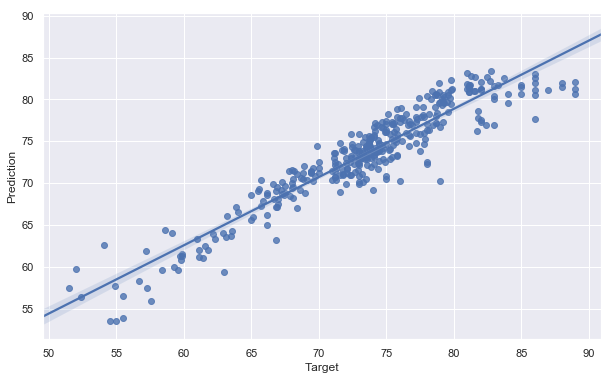

In [151]:
plt.figure(figsize=(10,6))
sns.regplot(x=ytest,y=predict)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

In [152]:
df_pf=pd.DataFrame(predict,columns=['Predicted'])

df_pf['Target']=ytest

df_pf['Residuals']=df_pf['Predicted']-df_pf['Target']

df_pf['Difference_%']=np.absolute(df_pf.Residuals/df_pf.Target*100)

In [153]:
df_pf.describe()

,Predicted,Target,Residuals,Difference_%
count,362.000000,362.000000,362.000000,362.000000
mean,73.481587,73.393923,0.087664,2.449698
std,5.998168,6.925453,2.404753,2.260249
min,53.479235,51.500000,-8.795478,0.044924
25%,70.694730,69.925000,-0.909900,0.803533
50%,73.960390,74.050000,0.382728,1.903781
75%,77.468044,77.800000,1.608791,3.282921
max,83.443767,89.000000,8.509549,15.729296


In [154]:
df_pf.sort_values(by=['Difference_%'],ascending=False).head(20)

,Predicted,Target,Residuals,Difference_%
55,62.609549,54.1,8.509549,15.729296
116,59.763422,52.0,7.763422,14.929658
261,57.532608,51.5,6.032608,11.713802
8,70.204522,79.0,-8.795478,11.133516
355,64.438811,58.6,5.838811,9.963842
75,77.693375,86.0,-8.306625,9.658866
144,80.633217,89.0,-8.366783,9.400880
117,81.247583,89.0,-7.752417,8.710581
324,64.074123,59.1,4.974123,8.416452
33,61.833208,57.2,4.633208,8.100014


## 6. Conclusion

It's observed that most number of observations having high difference % lies in the region of 50 to 60. This is worsening the result of our model. Also, gathering information from the scatter plot above, and using general inferences, we can conclude that our model can be made better by following ways:
- collect more number of observations for the range of 50 to 60.
- employ better methods of imputing missing values
- use the variable 'Country' instead of dropping
- collect more number of observations for lower life expectancy 
- use Regularization for relaxing parameter coefficients
- use non linear models

# Thank You!